In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import timm

from tqdm import tqdm
from torch import nn
from torch.nn import functional as F
#from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam

In [2]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

In [3]:
class ConvLSTM(nn.Module):

    """
    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True):
        super(ConvLSTM, self).__init__()

        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        
        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (batch, channels, time, height, width)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        layer_output_list, h_n (num_layers, batch, hidden_dim, height, width), cn
        """
        if not self.batch_first:
            # 
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)
        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b, image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(2)
        cur_layer_input = input_tensor

        h_n = []
        c_n = []
        
        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, :,t, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim = 2)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            h_n.append(h)
            c_n.append(c)
            
        return torch.stack(layer_output_list)[-1]
        return layer_output_list, (torch.stack(h_n), torch.stack(c_n))

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [4]:
class NextFramePredictionModel(nn.Module):
    def __init__(self, in_channels, hidden_dim, kernel_size, num_convlstm_layers = 1, num_lstmcell_layers = 1, batch_first = True):
        super().__init__()
        
        self.conv_lstm = nn.Sequential()
        
        self.conv_lstm.add_module(
            'convlstm0',ConvLSTM(in_channels, hidden_dim, kernel_size, num_lstmcell_layers, batch_first)
        )
        self.conv_lstm.add_module(
            'bn0', nn.BatchNorm3d(hidden_dim)
        )
        self.conv_lstm.add_module(
            f'bn{0}', nn.ReLU()
        )
        
        for i in range(1, num_convlstm_layers):
            self.conv_lstm.add_module(
            f'convlstm{i}',ConvLSTM(hidden_dim, hidden_dim, kernel_size, num_lstmcell_layers, batch_first)
        )
            self.conv_lstm.add_module(
            f'bn{i}', nn.BatchNorm3d(hidden_dim)
        )
        
            self.conv_lstm.add_module(
            f'bn{i}', nn.ReLU()
        )
            
        self.out = nn.Conv3d(in_channels = hidden_dim, out_channels = in_channels, kernel_size = 3, padding = 1, stride = 1)
        
    def forward(self, x):
        '''x: batch, channels,time, height, width'''
        x_shape = x.shape

        x = self.conv_lstm(x)
        
        x = self.out(x)
        
#         x = F.interpolate(x, x_shape[-2:], mode = 'bilinear')
            
        return F.sigmoid(x)

In [5]:
model = NextFramePredictionModel(1, 64, (3,3), 5, batch_first = True)
x = torch.rand(2,1,5,64,64)
y = model(x)
y.shape

torch.Size([2, 1, 5, 64, 64])

In [ ]:
def split_dataloader(train_data, validation_split = 0.2):
    
    train_ratio = 1 - validation_split  
    train_size = int(train_ratio * len(train_data.dataset))  

    indices = list(range(len(train_data.dataset)))  
    train_indices = indices[:train_size]  
    val_indices = indices[train_size:]  

    
    dataset = train_data.dataset
    batch_size = train_data.batch_size
    num_workers = train_data.num_workers
    
    
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_data = DataLoader(dataset, batch_size = batch_size, sampler = train_sampler, num_workers = 0, drop_last = True)
    val_data = DataLoader(dataset, batch_size = batch_size, sampler = val_sampler, num_workers = 0, drop_last = True)
    

    return train_data, val_data

In [ ]:
def evaluate(model, val_data, loss_fn, weights = None, device = 'cpu', verbose = 0):
    # set device
    if (device == 'gpu' or device == 'cuda') and torch.cuda.is_available():
        device = torch.device('cuda')
    elif isinstance(device, torch.device): 
        device = device
    else: 
        device = torch.device('cpu')
    
    model = model.to(device)

    if weights:
        model.load_state_dict(torch.load(weights))
        print('Weights loaded successfully from path:', weights)
        print('====================================================')
    
    with torch.no_grad():
        model.eval()
        val_correct = 0
        running_loss = 0.
        if verbose == 1:
            val_data = tqdm(val_data, desc = 'Evaluate: ', ncols = 100)
        for data_batch, label_batch in val_data:
            data_batch, label_batch = data_batch.to(device), label_batch.to(device)

           
            output_batch = model(data_batch)

            loss = loss_fn(output_batch, label_batch.float())
            running_loss += loss.item()

            
            predicted_labels = torch.round(output_batch.data)
            val_correct += (label_batch == predicted_labels).sum().item()/torch.prod(torch.tensor(label_batch.shape))
            
        val_loss = running_loss/len(val_data)
        val_acc = val_correct/len(val_data)
        return val_loss, val_acc

In [ ]:
def train(model, train_data, loss_fn, optimizer, epochs, weights = None, save_last_weights_path = None,
          save_best_weights_path = None, freeze = False, steps_per_epoch = None,
          device = 'cpu', validation_data = None, validation_split = None, scheduler = None):
    
    
    assert not(validation_data is not None and validation_split is not None)
    
    
    if weights:
        model.load_state_dict(torch.load(weights))
        print('Weights loaded successfully from path:', weights)
        print('====================================================')
    
    # set device
    if (device == 'gpu' or device == 'cuda') and torch.cuda.is_available():
        device = torch.device('cuda')
    elif isinstance(device, torch.device): 
        device = device
    else: 
        device = torch.device('cpu')
         
    if validation_data is not None:
        val_data = validation_data
    elif validation_split is not None: 
        train_data, val_data = split_dataloader(train_data, validation_split)
    else: 
        val_data = None
        
    # save best model
    if save_best_weights_path: 
        if val_data is None:
            train_data, val_data = split_dataloader(train_data, 0.2)
        best_loss, _ = evaluate(model, val_data, device = device, loss_fn = loss_fn)  
        
    
    if steps_per_epoch is None: 
        steps_per_epoch = len(train_data)

    num_steps = len(train_data)
    iterator = iter(train_data)
    count_steps = 1    
    
    ## History
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_acc': [],
        'val_loss': []
    }
        
    # add model to device
    model = model.to(device)
    
    ############################### Train and Val ##########################################
    for epoch in range(1, epochs + 1):
        # tính tổng giá trị hàm mất mát cho mỗi epoch
        running_loss = 0.
        train_correct = 0
        
        
        model.train()
        
        for step in tqdm(range(steps_per_epoch), desc = f'epoch: {epoch}/{epochs}: ', ncols = 100): 
            img_batch, label_batch = next(iterator)
            img_batch, label_batch = img_batch.to(device), label_batch.to(device)
            
            
            optimizer.zero_grad()
            
            
            output_batch = model(img_batch)
            
            
            loss = loss_fn(output_batch, label_batch.float())
            
            
            loss.backward()
            
            
            optimizer.step()
            
            
            predicted_labels = torch.round(output_batch.data)
            train_correct += (label_batch == predicted_labels).sum().item()/torch.prod(torch.tensor(label_batch.shape))
                
            
            running_loss += loss.item()
                
            if count_steps == num_steps:
                count_steps = 0
                iterator = iter(train_data)
            count_steps += 1
            
        train_loss = running_loss / steps_per_epoch
        train_accuracy = train_correct / steps_per_epoch
        
        # reduce lr
        if scheduler:
            scheduler.step(train_loss)
        
        history['train_loss'].append(float(train_loss))
        history['train_acc'].append(float(train_accuracy))
        
        if val_data is not None: 
            val_loss, val_acc = evaluate(model, val_data, device = device, loss_fn = loss_fn)
            print(f'epoch: {epoch}, train_accuracy: {train_accuracy: .2f}, loss: {train_loss: .3f}, val_accuracy: {val_acc: .2f}, val_loss: {val_loss:.3f}')

            if save_best_weights_path:
                if val_loss < best_loss:
                    best_loss = val_loss
                    torch.save(model.state_dict(), save_best_weights_path)
                    print(f'Saved successfully best weights to:', save_best_weights_path)
            history['val_loss'].append(float(val_loss))
            history['val_acc'].append(float(val_acc))
        else:
            print(f'epoch: {epoch}, train_accuracy: {train_accuracy: .2f}, loss: {train_loss: .3f}')
    if save_last_weights_path:  
        torch.save(model.state_dict(), save_last_weights_path)
        print(f'Saved successfully last weights to:', save_last_weights_path)
    return model, history

In [9]:
data_path = 'mnist_test_seq.npy'
last_weights = 'ConvLSTM.pt'

in_channels = 1
hidden_dim = 64
batch_first = True
batch_size = 4  
kernel_size = 3
num_workers = 0
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
# Load Data as Numpy Array
# num sample, length sequence, height, width
MovingMNIST = np.load(data_path).transpose(1, 0, 2, 3)

# Shuffle Data
np.random.shuffle(MovingMNIST)

subset_size = 1000  # Use a small subset
batch_size = 4  # Reduce batch size

# Train, Test, Validation splits
train_data = MovingMNIST[:subset_size]         
val_data = MovingMNIST[subset_size:subset_size + 200]       
test_data = MovingMNIST[subset_size + 200:subset_size + 300]     

def collate(batch):
    batch = np.array(batch)
    batch = torch.tensor(batch, dtype=torch.float32).unsqueeze(1)
    batch = batch / 255.0  # Normalize
    return batch[:, :, :-1], batch[:, :, 1:]  # Target should have same number of frames as output

     

# Training Data Loader
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, collate_fn=collate, drop_last = True, num_workers = 0)

# Validation Data Loader
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, collate_fn=collate, num_workers = 0)

In [11]:
model = NextFramePredictionModel(
    in_channels = in_channels, 
    hidden_dim = hidden_dim, 
    kernel_size = kernel_size, 
    num_convlstm_layers = 3,
    num_lstmcell_layers = 2,
    batch_first = True
)

optimizer = Adam(model.parameters(), lr = 1e-4)
loss_fn = nn.BCELoss()
scheduler = ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.25, patience = 3, verbose = 1)

c:\Users\ASUS\anaconda3\envs\deeplearning\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [12]:
total_params = sum(p.numel() for p in model.parameters())
print('Total parametes in model:', total_params)

Total parametes in model: 1627585


In [13]:
epochs = 10  # Reduce from 50 to 10
steps_per_epoch = 100 # Uses all available batches per epoch

model, history = train(model, train_loader, loss_fn, optimizer, weights=None, epochs=epochs,
              save_last_weights_path=last_weights, save_best_weights_path=None,
              device=device, validation_data=val_loader, steps_per_epoch=steps_per_epoch, scheduler=scheduler)


epoch: 1/10: 100%|████████████████████████████████████████████████| 100/100 [36:01<00:00, 21.61s/it]


epoch: 1, train_accuracy:  0.93, loss:  0.388, val_accuracy:  0.93, val_loss: 0.236


epoch: 2/10: 100%|████████████████████████████████████████████████| 100/100 [37:27<00:00, 22.48s/it]


epoch: 2, train_accuracy:  0.93, loss:  0.216, val_accuracy:  0.93, val_loss: 0.206


epoch: 3/10: 100%|████████████████████████████████████████████████| 100/100 [37:31<00:00, 22.52s/it]


epoch: 3, train_accuracy:  0.93, loss:  0.204, val_accuracy:  0.93, val_loss: 0.198


epoch: 4/10: 100%|████████████████████████████████████████████████| 100/100 [37:30<00:00, 22.50s/it]


epoch: 4, train_accuracy:  0.93, loss:  0.192, val_accuracy:  0.93, val_loss: 0.189


epoch: 5/10: 100%|████████████████████████████████████████████████| 100/100 [37:32<00:00, 22.53s/it]


epoch: 5, train_accuracy:  0.93, loss:  0.166, val_accuracy:  0.93, val_loss: 0.118


epoch: 6/10: 100%|████████████████████████████████████████████████| 100/100 [37:31<00:00, 22.52s/it]


epoch: 6, train_accuracy:  0.93, loss:  0.082, val_accuracy:  0.93, val_loss: 0.065


epoch: 7/10: 100%|████████████████████████████████████████████████| 100/100 [37:24<00:00, 22.44s/it]


epoch: 7, train_accuracy:  0.93, loss:  0.061, val_accuracy:  0.93, val_loss: 0.057


epoch: 8/10: 100%|█████████████████████████████████████████████| 100/100 [4:16:46<00:00, 154.07s/it]


epoch: 8, train_accuracy:  0.93, loss:  0.055, val_accuracy:  0.93, val_loss: 0.054


epoch: 9/10: 100%|████████████████████████████████████████████████| 100/100 [39:11<00:00, 23.51s/it]


epoch: 9, train_accuracy:  0.93, loss:  0.052, val_accuracy:  0.93, val_loss: 0.050


epoch: 10/10: 100%|███████████████████████████████████████████████| 100/100 [33:41<00:00, 20.21s/it]


epoch: 10, train_accuracy:  0.93, loss:  0.047, val_accuracy:  0.93, val_loss: 0.046
Saved successfully last weights to: ConvLSTM.pt


In [14]:
def visualize_history(history, metrics = ['acc', 'loss']):   
    
    if 'acc' in metrics:
        plt.figure(figsize = (10,6))
        plt.subplot(121)
        plt.plot(range(1, len(history['train_acc']) + 1), history['train_acc'], label = 'train_acc', c = 'r')
        plt.plot(range(1, len(history['val_acc']) + 1), history['val_acc'], label = 'val_acc', c = 'g')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

    if 'loss' in metrics:
        plt.subplot(122)
        plt.plot(range(1, len(history['train_loss']) + 1), history['train_loss'], label = 'train_loss', c = 'r')
        plt.plot(range(1, len(history['val_loss']) + 1), history['val_loss'], label = 'val_loss', c = 'g')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

Visualize history

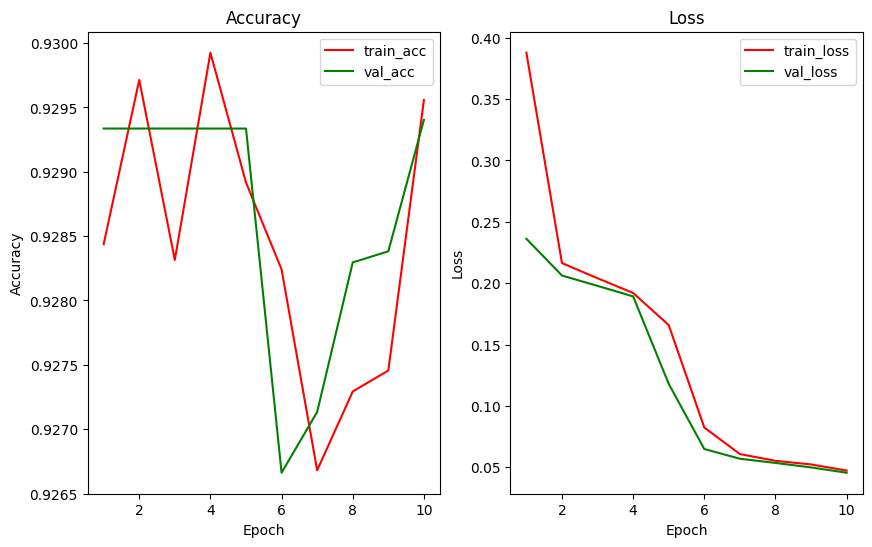

In [15]:
visualize_history(history)

Evaluate model

In [16]:
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, collate_fn=collate, num_workers = num_workers)
test_loss, test_acc = evaluate(model, weights = last_weights, val_data = test_loader, loss_fn = loss_fn, device = device, verbose = 1)
print(f'Loss: {test_loss : .3f}, Acc: {test_acc: .3f}')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_8692\2579665799.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights))


Weights loaded successfully from path: ConvLSTM.pt


Evaluate: 100%|█████████████████████████████████████████████████████| 25/25 [03:05<00:00,  7.44s/it]

Loss:  0.046, Acc:  0.930


Prediction

In [17]:
class prediction():
    def __init__(self, model, weights = None, device = 'cpu', num_time = None, output_sequence = False):
        if isinstance(device, str):
            if (device == 'gpu' or device == 'cuda') and torch.cuda.is_available():
                device = 'cuda'
            else:
                device = 'cpu'
        if weights:
            model.load_state_dict(torch.load(weights, map_location=torch.device(device)))
            print('Weights loaded successfully from path:', weights)
            print('====================================================')

        self.device = torch.device(device)
        self.model = model.to(self.device)
        self.output_sequence = output_sequence
        self.num_time = num_time 

    def infer(self, x):
        assert len(x.shape) in [4,5]
        '''x: batch, channels, time, height, width or time, channels, height, width'''
        x_shape = x.shape

        if not torch.is_tensor(x):
            if isinstance(x, np.ndarray):
                x = torch.from_numpy(x)
            else:
                x = torch.tensor(x)
        ori_x = x.clone()
        if len(x_shape) == 4:
            x = x.unsqueeze(0)

        # x: batch, channels, time, height, width
        if self.num_time:
            if x.shape[3] > self.num_time:
                x = x[:, :,-self.num_time:]

        if torch.max(x).item() > 1:
            x  = x/255.
        x = x.to(self.device)

        # y: batch, channels, height, width
        y = self.model(x)

        if len(x_shape) == 4:
            y = y.squeeze(dim = 0)

        y = y.cpu()

        if self.output_sequence:
            # y: channels, time, height, width
            if len(x_shape) == 4:
                y = torch.concat([ori_x, y[:, -2:-1]], dim = 1)
            else:
                y = torch.concat([ori_x, y[:,:, -2:-1]], dim = 2)
        return y.detach().numpy()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_8692\4117803341.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights, map_location=torch.d

Weights loaded successfully from path: ConvLSTM.pt
46


Text(0.5, 1.0, 'predict')

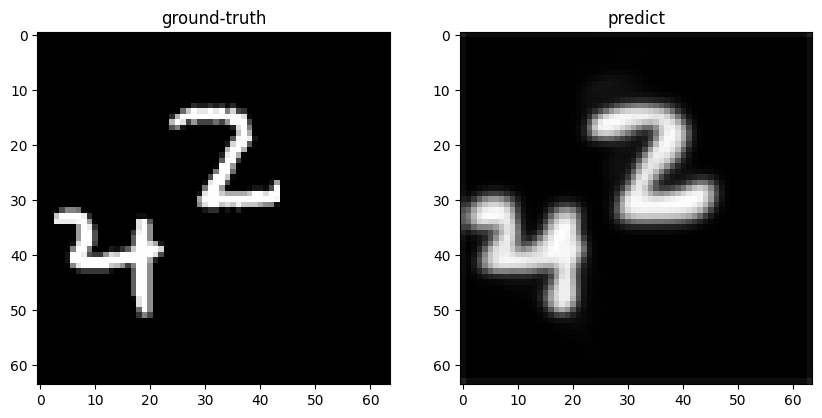

In [19]:
num_time = 19
predictor = prediction(model ,weights = last_weights, device = device, output_sequence = False, num_time = None)
idx = np.random.randint(0, len(test_data))  # Ensures the index is within bounds

sample = test_data[idx]
print(idx)
# add channels for sample
x = np.expand_dims(sample, axis = 0)
y = predictor.infer(x)

plt.figure(figsize = (10,8))
plt.subplot(121)
plt.imshow(sample[num_time], 'gray')
plt.title('ground-truth')

plt.subplot(122)
plt.imshow((y[0, 19]), 'gray')
plt.title('predict')

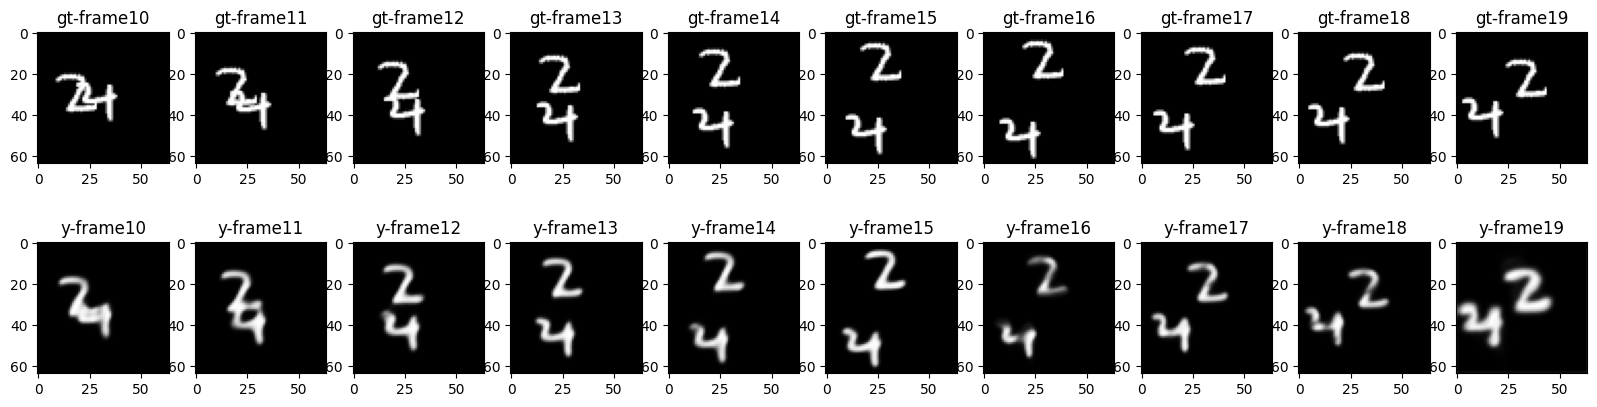

In [20]:
plt.figure(figsize = (20,5))
for i in range(1,11):
    plt.subplot(2,10,i)
    frame = i + 9
    # from frame 10
    plt.imshow(x[0, frame], 'gray')
    plt.title(f'gt-frame{frame}')
    
for i in range(11,21):
    plt.subplot(2,10,i)
    frame = i - 1
    # from frame 10
    plt.imshow(y[0, frame], 'gray')
    plt.title(f'y-frame{frame}')

In [22]:
predictor = prediction(model ,weights = last_weights, device = device, output_sequence = True, num_time = None)
num_frame_predict = 20
idx = np.random.randint(0, len(test_data))  # Ensure index is within valid range
x = test_data[idx]

# add channels for sample

x = np.expand_dims(x, axis = 0)

for i in range(num_frame_predict):
    x = predictor.infer(x)
x = x.squeeze(0)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_8692\4117803341.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights, map_location=torch.d

Weights loaded successfully from path: ConvLSTM.pt


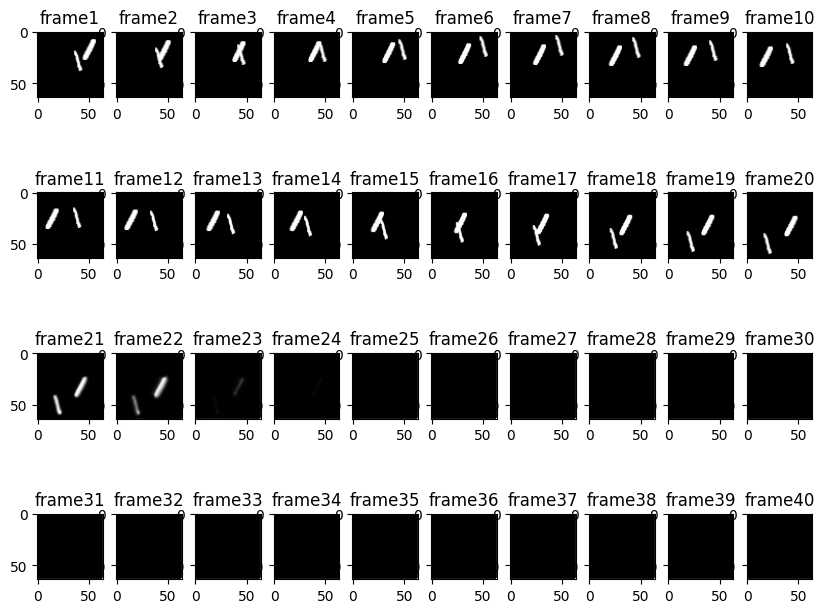

In [23]:
plt.figure(figsize = (10,8))
for i in range(1,41):
    plt.subplot(4,10,i)
    plt.imshow(x[i-1], 'gray')
    plt.title(f'frame{i}')

In [26]:
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
import imageio
import io
with io.BytesIO() as gif:
    imageio.mimsave(gif, x, format="GIF", duration=200)  # Fix format argument    
    output_gif = gif.getvalue()

display(HBox([widgets.Image(value=output_gif)]))
